In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
CMAP = cm.get_cmap('RdBu')
REF_RESULTS = pd.read_csv('reference_results.txt')

In [2]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    delta_bins, std_bins, err_bins: arrays
        Arrays of
    """
    
    digitized = np.digitize(x_values, bins)
    delta_bins, std_bins, err_bins = [], [], []
    
    for i in range(1, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            wmean = np.average(y, weights=w)
            werr = np.sqrt(np.sum(w*(y- wmean)**2)/((len(w)-1)*np.sum(w)))
            wstd = np.sqrt(np.average((y - wmean)**2, weights=w))
            
            delta_bins.append(wmean)
            std_bins.append(wstd)
            err_bins.append(werr)
        else:
            delta_bins.append(np.nan)
            std_bins.append(np.nan)
            err_bins.append(np.nan)

    delta_bins, std_bins, err_bins = np.array(delta_bins), np.array(std_bins), np.array(err_bins)
    
    return delta_bins, std_bins, err_bins

In [3]:
# SNe to remove
df1 = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
df2 = pd.read_csv('sne_wo_opt_max.txt', names=['name', 'comment'], delim_whitespace=True)
df3 = pd.read_csv('sne_wo_nir_max.txt', names=['name', 'comment'], delim_whitespace=True)
del_df = pd.concat([df1, df2, df3])
files2remove = [f'csp_dr3/{name}_snpy.txt' for name in list(del_df.name.values)]

sn_names = [file.split('/')[-1].split('_')[0] for file in glob.glob('csp_dr3/*.txt') 
                                                            if file not in files2remove]

In [4]:
ref_bands = 'AllBands'
n_epochs = 1

param = 'Jmax'
if param=='Tmax':
    x_units = 'days'
else:
    x_units = 'mag'

In [26]:
sim_file = os.path.join('sim_fits', 
                                    'SN2004eo', 
                                    f'SN2004eo_1epochs_results.csv')

sim_df = pd.read_csv(sim_file)
sim_df.Tmax.values - REF_RESULTS[REF_RESULTS.name=='SN2004eo'].Tmax_AllBands.values[0]

array([278.4161048 , 278.41526286, 278.41528538, 278.41541645,
       278.41533942, 278.41510996, 278.41385215, 278.4136464 ])

In [27]:
REF_RESULTS[REF_RESULTS.name=='SN2004eo'].Tmax_AllBands.values[0]

0.81639006671055

In [20]:
REF_RESULTS[REF_RESULTS.name=='SN2004eo']

,name,Tmax_gr,Tmax_err_gr,Tmax_grJH,Tmax_err_grJH,Tmax_AllBands,Tmax_err_AllBands,gmax_gr,gmax_err_gr,gmax_grJH,...,Jmax_grJH,Jmax_err_grJH,Jmax_AllBands,Jmax_err_AllBands,Hmax_gp,Hmax_err_gp,Hmax_grJH,Hmax_err_grJH,Hmax_AllBands,Hmax_err_AllBands
4,SN2004eo,0.817494,0.008583,0.818089,0.00759,0.81639,0.004646,15.034402,0.010201,15.034252,...,15.422795,0.027491,15.417057,0.028564,15.700389,0.022261,15.612701,0.037435,15.624596,0.038838


In [5]:
def plot_m1(param, ref_bands):
    colors  = sns.color_palette('tab10')[1:]
    i = 0
    fig, ax = plt.subplots(figsize=(8, 6))
    
    X, Y, YERR = [], [], []
    for sn_name in REF_RESULTS.name:
        try:
            #ref
            ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]
            y_ref = ref_df[f'{param}_{ref_bands}'].values[0]

            # sim
            sim_file = os.path.join('sim_fits', 
                                    sn_name, 
                                    f'{sn_name}_1epochs_results.csv')
            sim_df = pd.read_csv(sim_file)
            m1 = sim_df.m1.values
            y = sim_df[param].values
            yerr = sim_df[param+'_err'].values        

            residual = y-y_ref
            
            #detect outliers
            if np.any(np.abs(residual)>0.4):
                color = colors[i]
                label = sn_name
                i+= 1
            else:
                color = 'b'
                label = None
            
            # plot
            ax.errorbar(m1, residual, yerr=yerr, 
                                fmt='o', color=color, alpha=0.5,
                                mec='k', label=label)

            X.append(m1), Y.append(residual), YERR.append(yerr)
        except:
            pass

    # bins
    X = np.array([item for sublist in X for item in sublist])
    Y = np.array([item for sublist in Y for item in sublist])
    YERR = np.array([item for sublist in YERR for item in sublist])

    bins = np.arange(np.round(X, 0).min(), np.round(X+1, 0).max(), 2)
    delta_bins, std_bins, err_bins = bin_values(bins, X, Y, YERR)
    ax.errorbar(bins[:-1], delta_bins, err_bins, 
                color='red', zorder=18, ms=8, mec='k', fmt='h', ecolor='red', 
                capsize=8, capthick=2, elinewidth=2.5)
    
    ax.axhline(0, color='k', ls='--')
    ax.set_xlabel('m1 (days)', fontsize=16)
    ax.set_ylabel(f'{param} residual ({x_units})', fontsize=16)
    ax.legend()
    plt.show()

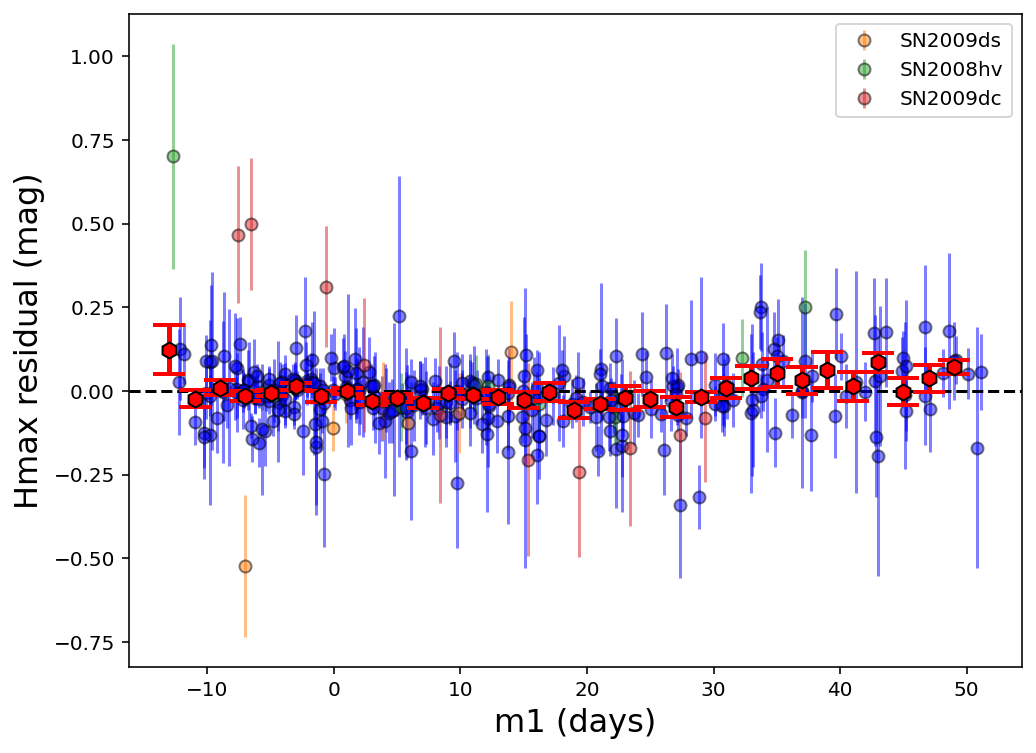

In [6]:
plot_m1('Hmax', ref_bands)

In [7]:
def plot_m2(param, ref_bands):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # colour bar
    norm = colors.Normalize(vmin=-0.11, vmax=0.11)
    s_m = plt.cm.ScalarMappable(cmap=CMAP, norm=norm)
    s_m.set_array([])
    
    for sn_name in REF_RESULTS.name:
        try:
            # ref
            ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]
            y_ref = ref_df[f'{param}_{ref_bands}'].values[0]

            # sim
            sim_file = os.path.join('sim_fits', 
                                    sn_name, 
                                    f'{sn_name}_2epochs_results.csv')
            sim_df = pd.read_csv(sim_file)
            m1 = sim_df.m1.values
            m2 = sim_df.m2.values

            y = sim_df[param].values
            yerr = sim_df[param+'_err'].values     

            residual = y-y_ref
            
            # plot
            ax.scatter(m1, m2, s=50, marker='o', edgecolors='k', 
                       c=s_m.to_rgba(residual), alpha=0.8)
        except:
            pass

    cbar = plt.colorbar(s_m, ax=ax)
    cbar.set_label(f'{param} residual (mag)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 16
    cbar.ax.tick_params(labelsize=16)
    
    plt.show()

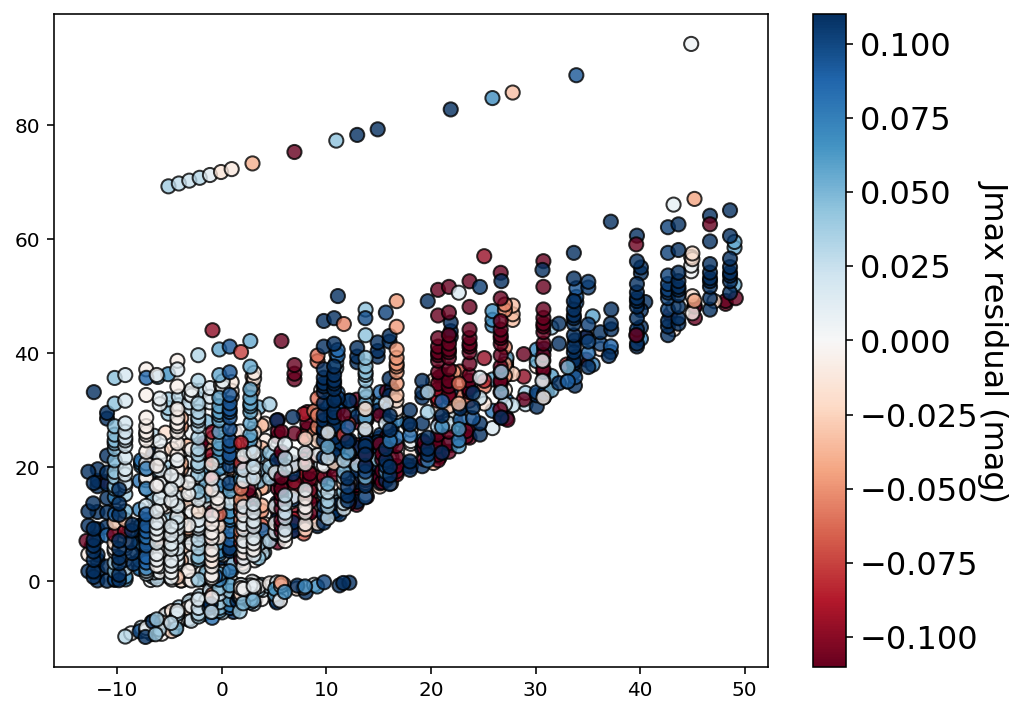

In [8]:
plot_m2('Jmax', ref_bands)

In [9]:
def plot_m3(param, ref_bands):
    
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), 
                       gridspec_kw={'hspace':0, 'wspace':0})
    
    # colour bar
    norm = colors.Normalize(vmin=-0.11, vmax=0.11)
    s_m = plt.cm.ScalarMappable(cmap=CMAP, norm=norm)
    s_m.set_array([])
    
    for sn_name in REF_RESULTS.name:
        try:
            # ref
            ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]
            y_ref = ref_df[f'{param}_{ref_bands}'].values[0]

            # sim
            sim_file = os.path.join('sim_fits', 
                                    sn_name, 
                                    f'{sn_name}_3epochs_results.csv')
            sim_df = pd.read_csv(sim_file)
            m1 = sim_df.m1.values
            m2 = sim_df.m2.values
            m3 = sim_df.m3.values

            y = sim_df[param].values
            yerr = sim_df[param+'_err'].values     

            residual = y-y_ref

            # plot
            ax[0, 0].scatter(m1, m2, s=50, marker='o', edgecolors='k', 
                             c=s_m.to_rgba(residual), alpha=0.8)
            ax[1, 0].scatter(m1, m3, s=50, marker='o', edgecolors='k', 
                             c=s_m.to_rgba(residual), alpha=0.8)
            ax[1, 1].scatter(m2, m3, s=50, marker='o', edgecolors='k', 
                             c=s_m.to_rgba(residual), alpha=0.8)
        except:
            pass

    ax[0, 1].set_aspect(6)
    cbar = plt.colorbar(s_m, cax=ax[0, 1])
    cbar.set_label(f'{param} residual (mag)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 16
    cbar.ax.tick_params(labelsize=16)
    
    plt.show()

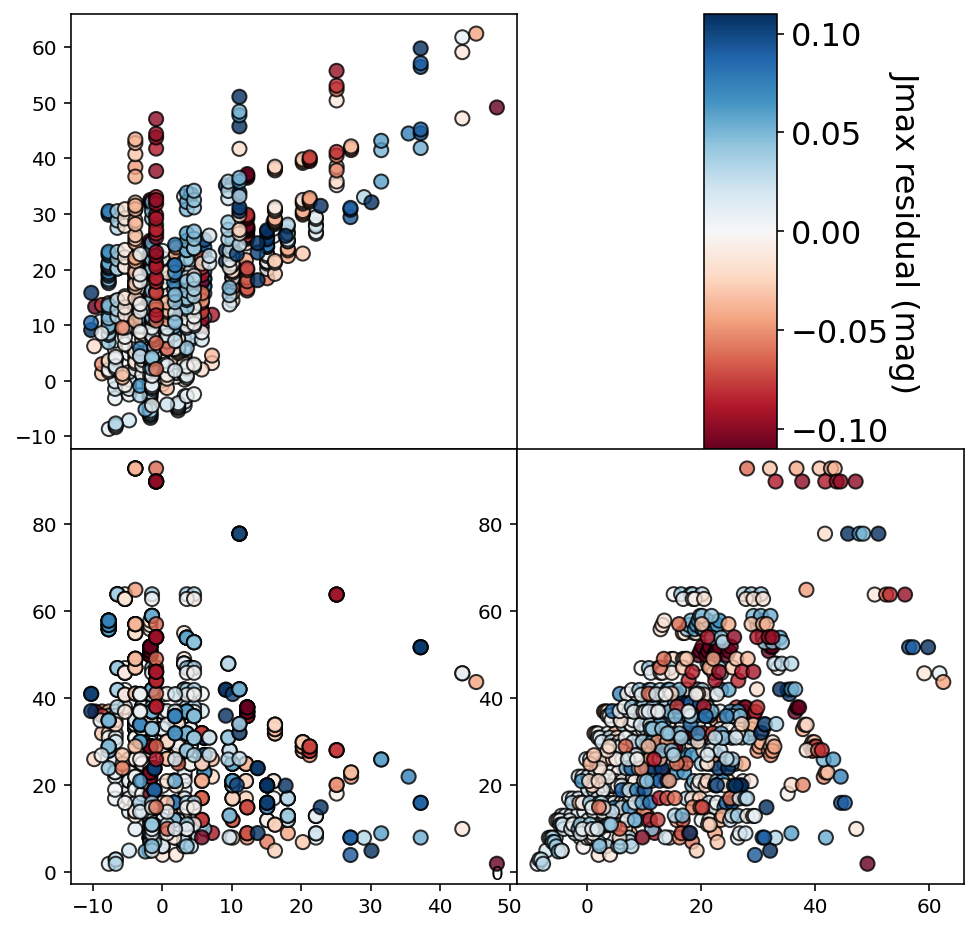

In [10]:
plot_m3('Jmax', ref_bands)

In [11]:
def master_plot(param, ref_bands, n_epochs):
    
    assert 1<=n_epochs<=3, '`n_epochs` must be 1, 2 or 3'
    
    if n_epochs==1:
        plot_m1(param, ref_bands)
    elif n_epochs==2:
        plot_m2(param, ref_bands)
    elif n_epochs==3:
        plot_m3(param, ref_bands)

/home/tomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


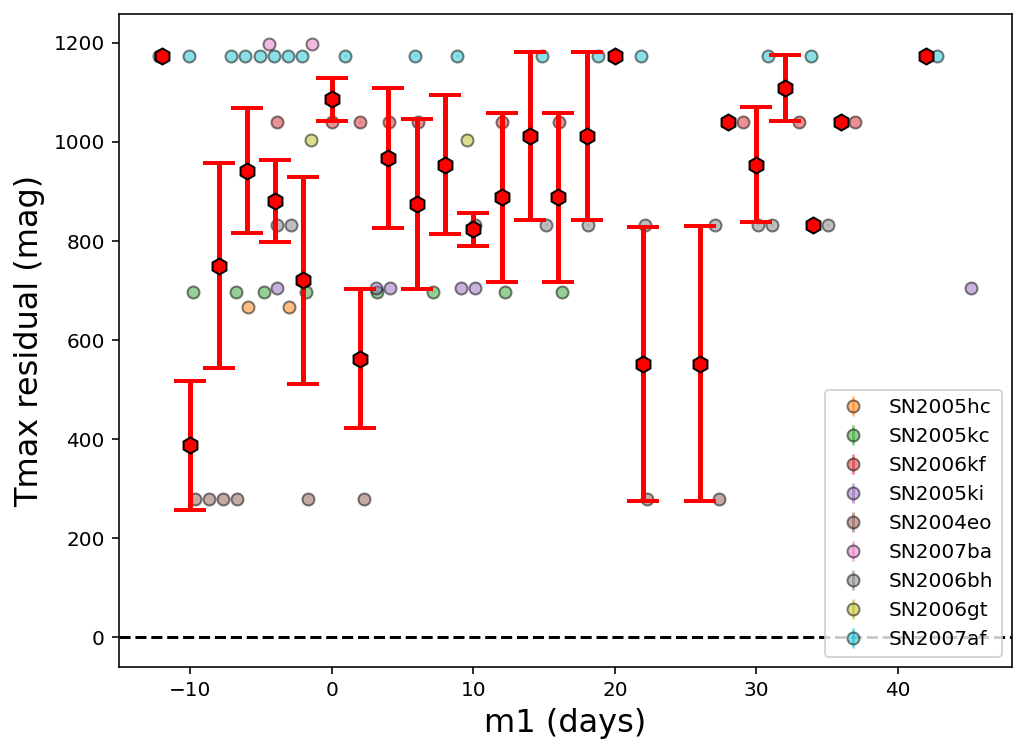

In [16]:
master_plot('Tmax', ref_bands, 1)